# 多层感知机
1. 多层感知机的基本知识
2. 使用多层感知机图像分类的从零开始的实现
3. 使用pytorch的简洁实现

## 多层感知机的基本知识
深度学习主要关注多层模型。在这里，我们将以多层感知机（multilayer perceptron，MLP）为例，介绍多层神经网络的概念。

### 隐藏层
下图展示了一个多层感知机的神经网络图，它含有一个隐藏层，该层中有5个隐藏单元。

![Image Name](https://cdn.kesci.com/upload/image/q5ho684jmh.png)

### 表达公式
具体来说，给定一个小批量样本$\boldsymbol{X} \in \mathbb{R}^{n \times d}$，其批量大小为$n$，输入个数为$d$。假设多层感知机只有一个隐藏层，其中隐藏单元个数为$h$。记隐藏层的输出（也称为隐藏层变量或隐藏变量）为$\boldsymbol{H}$，有$\boldsymbol{H} \in \mathbb{R}^{n \times h}$。因为隐藏层和输出层均是全连接层，可以设隐藏层的权重参数和偏差参数分别为$\boldsymbol{W}_h \in \mathbb{R}^{d \times h}$和 $\boldsymbol{b}_h \in \mathbb{R}^{1 \times h}$，输出层的权重和偏差参数分别为$\boldsymbol{W}_o \in \mathbb{R}^{h \times q}$和$\boldsymbol{b}_o \in \mathbb{R}^{1 \times q}$。

我们先来看一种含单隐藏层的多层感知机的设计。其输出$\boldsymbol{O} \in \mathbb{R}^{n \times q}$的计算为


$$
 \begin{aligned} \boldsymbol{H} &= \boldsymbol{X} \boldsymbol{W}_h + \boldsymbol{b}_h,\\ \boldsymbol{O} &= \boldsymbol{H} \boldsymbol{W}_o + \boldsymbol{b}_o, \end{aligned}
$$


也就是将隐藏层的输出直接作为输出层的输入。如果将以上两个式子联立起来，可以得到


$$
 \boldsymbol{O} = (\boldsymbol{X} \boldsymbol{W}_h + \boldsymbol{b}_h)\boldsymbol{W}_o + \boldsymbol{b}_o = \boldsymbol{X} \boldsymbol{W}_h\boldsymbol{W}_o + \boldsymbol{b}_h \boldsymbol{W}_o + \boldsymbol{b}_o. 
$$


从联立后的式子可以看出，虽然神经网络引入了隐藏层，却依然等价于一个单层神经网络：其中输出层权重参数为$\boldsymbol{W}_h\boldsymbol{W}_o$，偏差参数为$\boldsymbol{b}_h \boldsymbol{W}_o + \boldsymbol{b}_o$。不难发现，即便再添加更多的隐藏层，以上设计依然只能与仅含输出层的单层神经网络等价。

### 激活函数
上述问题的根源在于全连接层只是对数据做仿射变换（affine transformation），而多个仿射变换的叠加仍然是一个仿射变换。解决问题的一个方法是引入非线性变换，例如对隐藏变量使用按元素运算的非线性函数进行变换，然后再作为下一个全连接层的输入。这个非线性函数被称为激活函数（activation function）。

下面我们介绍几个常用的激活函数：


#### ReLU函数
ReLU（rectified linear unit）函数提供了一个很简单的非线性变换。给定元素$x$，该函数定义为


$$
\text{ReLU}(x) = \max(x, 0).
$$


可以看出，ReLU函数只保留正数元素，并将负数元素清零。为了直观地观察这一非线性变换，我们先定义一个绘图函数xyplot。

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../utils/")
import d2lzh as d2l
print(torch.__version__)

1.2.0


In [2]:
def xyplot(x_vals, y_vals, name):
    # d2l.set_figsize(figsize=(5, 2.5))
    plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    plt.xlabel('x')
    plt.ylabel(name + '(x)')

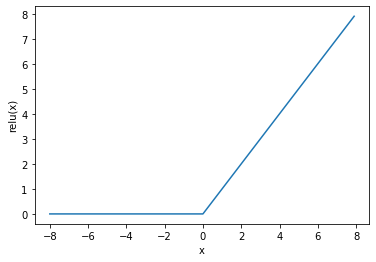

In [3]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
xyplot(x, y, 'relu')

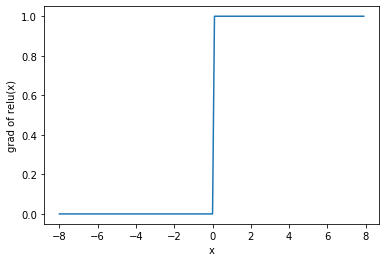

In [4]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

#### Sigmoid函数
sigmoid函数可以将元素的值变换到0和1之间：


$$
\text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$




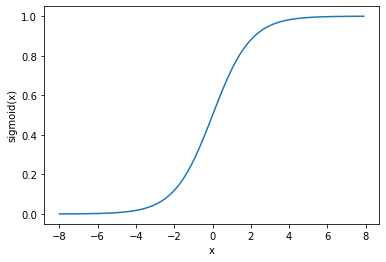

In [5]:
y = x.sigmoid()
xyplot(x, y, 'sigmoid')

依据链式法则，sigmoid函数的导数


$$
\text{sigmoid}'(x) = \text{sigmoid}(x)\left(1-\text{sigmoid}(x)\right).
$$


下面绘制了sigmoid函数的导数。当输入为0时，sigmoid函数的导数达到最大值0.25；当输入越偏离0时，sigmoid函数的导数越接近0。

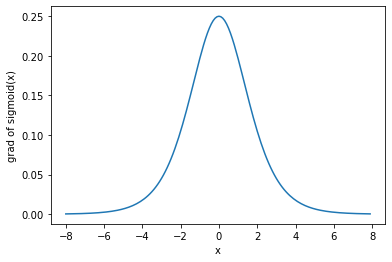

In [6]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

#### tanh函数
tanh（双曲正切）函数可以将元素的值变换到-1和1之间：


$$
\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.
$$


我们接着绘制tanh函数。当输入接近0时，tanh函数接近线性变换。虽然该函数的形状和sigmoid函数的形状很像，但tanh函数在坐标系的原点上对称。

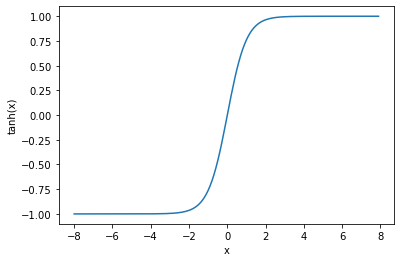

In [7]:
y = x.tanh()
xyplot(x, y, 'tanh')

依据链式法则，tanh函数的导数


$$
\text{tanh}'(x) = 1 - \text{tanh}^2(x).
$$


下面绘制了tanh函数的导数。当输入为0时，tanh函数的导数达到最大值1；当输入越偏离0时，tanh函数的导数越接近0。

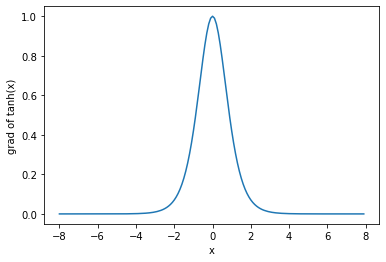

In [8]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of tanh')

### 关于激活函数的选择

ReLu函数是一个通用的激活函数，目前在大多数情况下使用。但是，ReLU函数只能在隐藏层中使用。

用于分类器时，sigmoid函数及其组合通常效果更好。由于梯度消失问题，有时要避免使用sigmoid和tanh函数。  

在神经网络层数较多的时候，最好使用ReLu函数，ReLu函数比较简单计算量少，而sigmoid和tanh函数计算量大很多。

在选择激活函数的时候可以先选用ReLu函数如果效果不理想可以尝试其他激活函数。

### 多层感知机
多层感知机就是含有至少一个隐藏层的由全连接层组成的神经网络，且每个隐藏层的输出通过激活函数进行变换。多层感知机的层数和各隐藏层中隐藏单元个数都是超参数。以单隐藏层为例并沿用本节之前定义的符号，多层感知机按以下方式计算输出：


$$
 \begin{aligned} \boldsymbol{H} &= \phi(\boldsymbol{X} \boldsymbol{W}_h + \boldsymbol{b}_h),\\ \boldsymbol{O} &= \boldsymbol{H} \boldsymbol{W}_o + \boldsymbol{b}_o, \end{aligned} 
$$


其中$\phi$表示激活函数。

## 多层感知机从零开始的实现

In [9]:
import torch
import numpy as np
import sys
sys.path.append("../utils/")
import d2lzh as d2l
print(torch.__version__)

1.2.0


### 获取训练集

In [10]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size,root='../datasets/FashionMNIST')

### 定义模型参数

In [11]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

### 定义激活函数

In [12]:
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

### 定义网络

In [13]:
def net(X):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

### 定义损失函数

In [14]:
loss = torch.nn.CrossEntropyLoss()

### 训练

In [15]:
num_epochs, lr = 5, 100.0
# def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
#               params=None, lr=None, optimizer=None):
#     for epoch in range(num_epochs):
#         train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
#         for X, y in train_iter:
#             y_hat = net(X)
#             l = loss(y_hat, y).sum()
#             
#             # 梯度清零
#             if optimizer is not None:
#                 optimizer.zero_grad()
#             elif params is not None and params[0].grad is not None:
#                 for param in params:
#                     param.grad.data.zero_()
#            
#             l.backward()
#             if optimizer is None:
#                 d2l.sgd(params, lr, batch_size)
#             else:
#                 optimizer.step()  # “softmax回归的简洁实现”一节将用到
#             
#             
#             train_l_sum += l.item()
#             train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
#             n += y.shape[0]
#         test_acc = evaluate_accuracy(test_iter, net)
#         print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
#               % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0031, train acc 0.711, test acc 0.793
epoch 2, loss 0.0019, train acc 0.822, test acc 0.840
epoch 3, loss 0.0017, train acc 0.842, test acc 0.781
epoch 4, loss 0.0015, train acc 0.856, test acc 0.818
epoch 5, loss 0.0015, train acc 0.863, test acc 0.783


## 多层感知机pytorch实现

In [16]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
sys.path.append("../utils/")
import d2lzh as d2l

print(torch.__version__)

1.2.0


### 初始化模型和各个参数

In [17]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
    
net = nn.Sequential(
        d2l.FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens, num_outputs), 
        )
    
for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

### 训练

In [18]:
batch_size = 256
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.701, test acc 0.753
epoch 2, loss 0.0019, train acc 0.822, test acc 0.802
epoch 3, loss 0.0017, train acc 0.842, test acc 0.827
epoch 4, loss 0.0015, train acc 0.853, test acc 0.839
epoch 5, loss 0.0014, train acc 0.863, test acc 0.826
